# **Import Packages**

In [26]:
# !pip install plotly==5.4.0
# !pip install chart_studio

In [1]:
import os
import time
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import style
import plotly.offline as pyoff
import plotly.graph_objs as go

from My_code.Metrics import *
import TrainingCode as trc
import TestingCode as tec

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import xgboost
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

style.use('seaborn-whitegrid')
os.getcwd()

'/Linux/[2021, 2022] 초분광(Hyperspectral) 데이터/[ 2022 ]/PSC'

# **Model - YP**

In [28]:
target = "chlorophyll"

In [29]:
data_yp = pd.read_csv("../DAT/complete_data(yp).csv")
data_yp = data_yp.fillna(0)

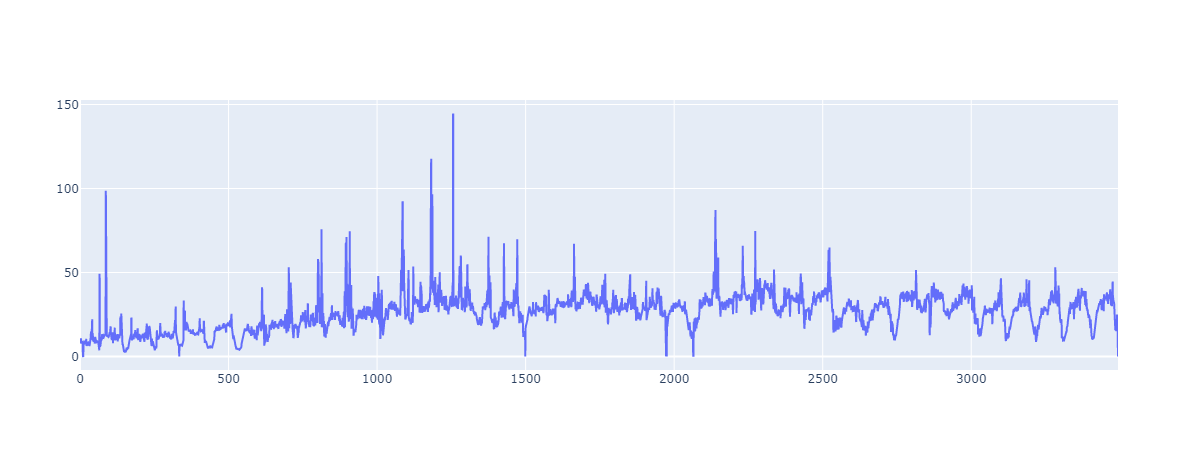

In [30]:
data_yp_34 = data_yp[data_yp["Month"].isin([3, 4])]
go.Figure(data = go.Scatter(y = data_yp_34[target], x = data_yp.index, mode='lines'))

In [31]:
data_yp_train = data_yp_34[data_yp_34["Month"] == 3].reset_index(drop=True)
data_yp_test = data_yp_34[data_yp_34["Month"] == 4].reset_index(drop=True)

print(data_yp_train.shape, data_yp_test.shape)

(2969, 569) (526, 569)


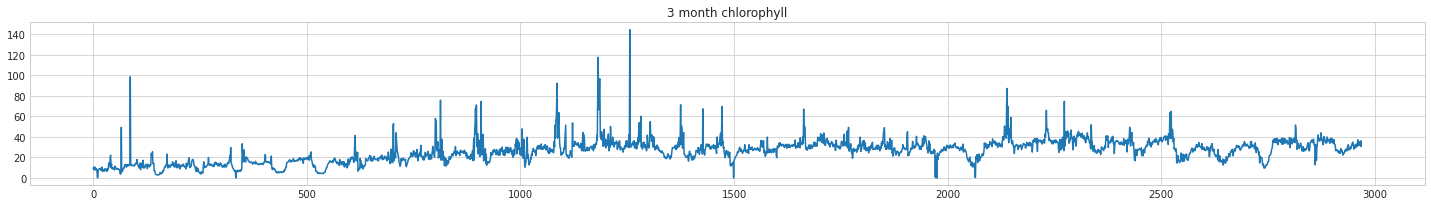

In [32]:
plt.figure(figsize = (25,3))
plt.plot(data_yp_train[target])
plt.title("3 month " + target);

In [33]:
# parameters = {'max_depth': list(range(1, 21, 5)), 
#               'min_samples_leaf': list(range(1, 6, 2)), 
#               'min_samples_split':list(range(1, 6, 2)), 
#               'n_estimators': list(range(100, 200, 20))}

### 기본 설정
lag_term = 1
Random_state = 717
before_y = "no"
hs = "yes"
# MODELS = [RandomForestRegressor(random_state = Random_state), ExtraTreesRegressor(random_state = Random_state), AdaBoostRegressor(random_state = Random_state), xgboost.XGBRegressor(random_state = Random_state), 
#           GradientBoostingRegressor(random_state = Random_state), LGBMRegressor(random_state = Random_state), CatBoostRegressor(random_state = Random_state, verbose = 0)]
MODELS = [RandomForestRegressor(random_state = Random_state), xgboost.XGBRegressor(random_state = Random_state), LGBMRegressor(random_state = Random_state)]

In [34]:
### 기본 모델
model = trc.HS_model(data_yp_train, MODEL = GradientBoostingRegressor(random_state = Random_state), lag_term = lag_term, before_y = before_y, hs = hs, target = target)["model"]
print(model)

GradientBoostingRegressor(random_state=717)


In [35]:
import warnings
warnings.filterwarnings('ignore')


### 예측 과정
dataset = data_yp_train.copy()  # 데이터가 쌓일 공간
preds = []
pred_X_df = pd.DataFrame()
for i in tqdm(range(data_yp_test.shape[0])) :
    
    dataset = dataset.append(data_yp_test.iloc[[i]])
    last_data = dataset.iloc[[-1]]
    
    """ 매 0시0분 Model Update """
    if (last_data["Hour"].values == 0) & (last_data["Min"].values == 0) :
        print("\033[31m" +"%d년 %d월 %d일 %d시 %d분 Model Update 수행합니다." % (last_data["Year"], last_data["Month"], last_data["Day"], last_data["Hour"], last_data["Min"]) + "\033[0m")
        
        start_time = time.time()
        
        hs_models, models = [], []
        for j in range(len(MODELS)) :
            hs_model = trc.HS_model(dataset, MODEL = MODELS[j], lag_term = lag_term, before_y = before_y, hs = hs, target = target)
            hs_models.append(hs_model)
            models.append(hs_model["model"])

        train_pls = hs_models[0]["train pls"]
        train_std_other = hs_models[0]["train std other"]
        train_std_reflec = hs_models[0]["train std reflec"]
        train_columns = hs_models[0]["train columns"]
        
        end_time = time.time()
        print("%.3f 경과시간" % (np.round(end_time - start_time, 3)))

        
    else :
        pass
    
    """ Prediction """
    pred_X = tec.testlag_(dataset, last_data, lag_term = lag_term, before_y = before_y)
    pred_X = tec.prep_data_with_y(pred_X, train_pls, train_std_other, train_std_reflec, hs = hs)
    pred_X = pred_X[train_columns]
    pred_X_df = pd.concat([pred_X_df, pred_X], axis = 0)    
    
    pred_list = []
    for j in range(len(models)) :
        pred_ = models[j].predict(pred_X)[0]
        pred_list.append(pred_)
        
    pred = np.mean(pred_list)
    
    preds.append(pred)   
    
    if i%50 == 0 :
        print("%d년 %d월 %d일 %d시 %d분 + 15분 후 예측값 : %.4f" % (last_data["Year"], last_data["Month"], last_data["Day"], last_data["Hour"], last_data["Min"], pred))

  0%|          | 0/526 [00:00<?, ?it/s]

2022년 4월 1일 0시 0분 Model Update 수행합니다.
3.022 경과시간
2022년 4월 1일 0시 0분 + 15분 후 예측값 : 39.2233
2022년 4월 1일 12시 30분 + 15분 후 예측값 : 21.5129
2022년 4월 2일 0시 0분 Model Update 수행합니다.
3.265 경과시간
2022년 4월 2일 1시 0분 + 15분 후 예측값 : 26.1352
2022년 4월 2일 13시 45분 + 15분 후 예측값 : 15.5414
2022년 4월 3일 0시 0분 Model Update 수행합니다.
3.216 경과시간
2022년 4월 3일 2시 15분 + 15분 후 예측값 : 31.7243
2022년 4월 3일 14시 45분 + 15분 후 예측값 : 11.1644
2022년 4월 4일 0시 0분 Model Update 수행합니다.
3.289 경과시간
2022년 4월 4일 3시 30분 + 15분 후 예측값 : 37.7374
2022년 4월 4일 16시 0분 + 15분 후 예측값 : 14.5006
2022년 4월 5일 0시 0분 Model Update 수행합니다.
3.387 경과시간
2022년 4월 5일 4시 30분 + 15분 후 예측값 : 32.4777
2022년 4월 5일 17시 0분 + 15분 후 예측값 : 20.9698
2022년 4월 6일 0시 0분 Model Update 수행합니다.
3.416 경과시간
2022년 4월 6일 5시 30분 + 15분 후 예측값 : 35.4414


R-square(OLS) :  0.827
R-square(sklearn) :  0.826
Correlation :  0.91
MAPE :  261043343.1


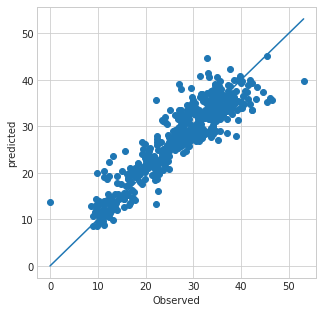

In [36]:
observed = list(data_yp_test.loc[1:, target].reset_index(drop = True))
preds2 = preds[:-1]

print("R-square(OLS) : ", R2_OLS(observed, preds2))
print("R-square(sklearn) : ", np.round(r2_score(observed, preds2), 3))
print("Correlation : ", np.round(np.corrcoef(observed, preds2)[0,1], 3))
print("MAPE : ", MAPE(observed, preds2))

plt.figure(figsize = (5,5))
plt.scatter(observed, preds2)
plt.xlabel("Observed") ; plt.ylabel("predicted")
plt.plot([0, max(max(observed), max(preds2))], [0, max(max(observed), max(preds2))]);

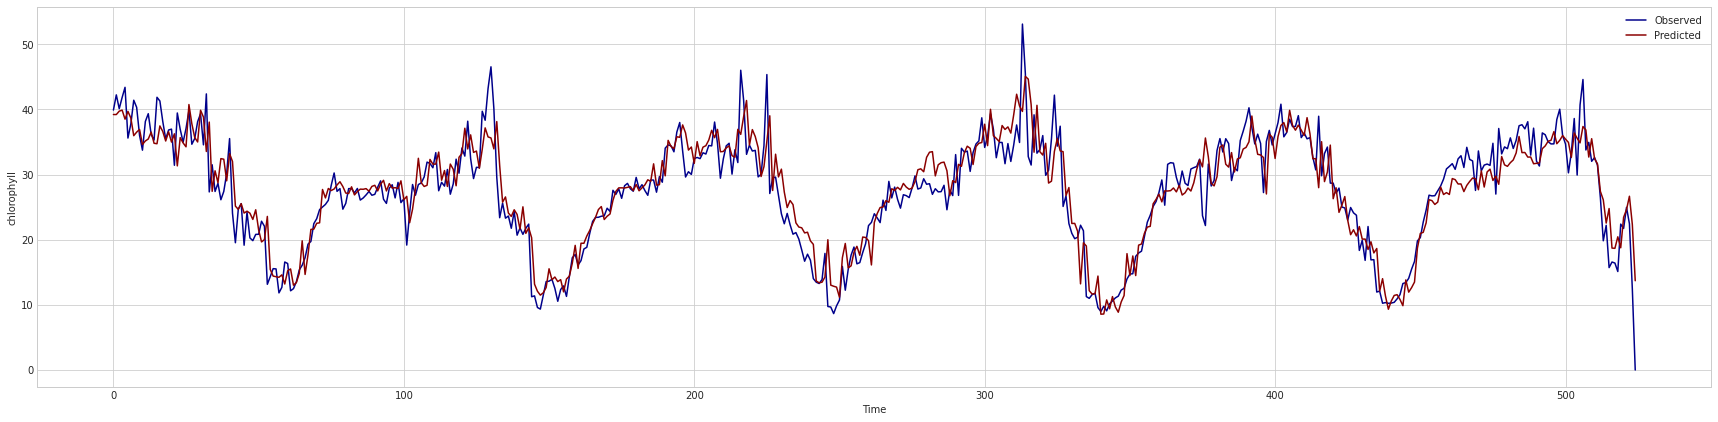

In [37]:
plt.figure(figsize = (30, 7))
plt.plot(observed, color = "darkblue", label = "Observed")
plt.plot(preds2, color = "darkred", label = "Predicted")
plt.xlabel("Time") ; plt.ylabel(target)

plt.legend();

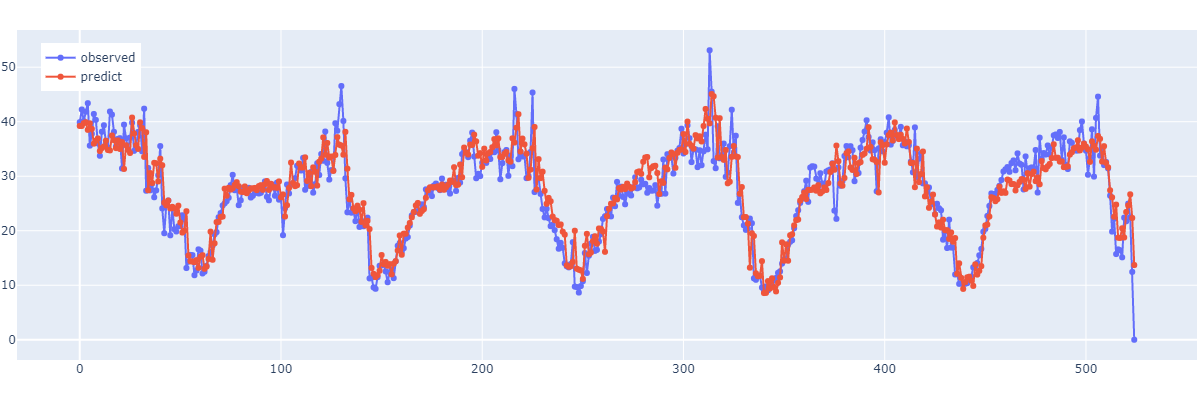

In [38]:
fig = go.Figure()
fig.update_layout(width = 1450, height = 400, margin = dict(l = 1, r = 1, t = 30, b = 40),
                  legend = dict(yanchor='top', y=0.96, xanchor='left', x=0.02))
fig.add_trace(go.Scatter(y = observed, x = list(range(len(observed))), mode = 'lines+markers', name = "observed"))
fig.add_trace(go.Scatter(y = preds2, x = list(range(len(preds2))), mode = 'lines+markers', name = "predict"))
fig.show();

# **Model - HA (chlorophyll)**

In [56]:
target = "chlorophyll"

In [57]:
data_ha = pd.read_csv("../DAT/complete_data(haman).csv")
data_ha = data_ha.fillna(0)

In [58]:
condlist = [((data_ha["Month"] == 5) & (data_ha["Day"] >= 23)), ((data_ha["Month"] == 6) & (data_ha["Day"] <= 8))]
choicelist = [1, 1]
use = np.select(condlist, choicelist).astype("int")
data_ha["use"] = use

data_ha_use = data_ha[data_ha["use"] == 1]
data_ha_use.drop(columns = ["use"], inplace = True)
data_ha_use.reset_index(drop = True, inplace = True)
data_ha_use.head(3)

Year  Month  Day  Hour  Min  chlorophyll  conductivity     do     ph  \
0  2022      5   23     0    0         7.29        377.99  11.93  8.728   
1  2022      5   23     0   15        18.72        377.76  11.96  8.730   
2  2022      5   23     0   30         7.44        378.67  11.86  8.703   

   phycocyanin  ...  reflectance.541  reflectance.542  reflectance.543  \
0         0.26  ...              0.0              0.0              0.0   
1         0.29  ...              0.0              0.0              0.0   
2         0.23  ...              0.0              0.0              0.0   

   reflectance.544  reflectance.545  reflectance.546  reflectance.547  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   

   reflectance.548  reflectance.549  reflectance.550  
0              0.0              0.0              0.0  
1              0.0              0.0              0.0  
2              0.0              0.0              0.0  

[3 rows x 569 columns]

In [59]:
data_ha_train = data_ha_use[(data_ha_use["Month"] != 6) & (data_ha_use["Day"] != 7)].reset_index(drop=True)
data_ha_test = data_ha_use[(data_ha_use["Month"] == 6) & (data_ha_use["Day"] == 7)].reset_index(drop=True)

print(data_ha_train.shape, data_ha_test.shape)

(864, 569) (96, 569)


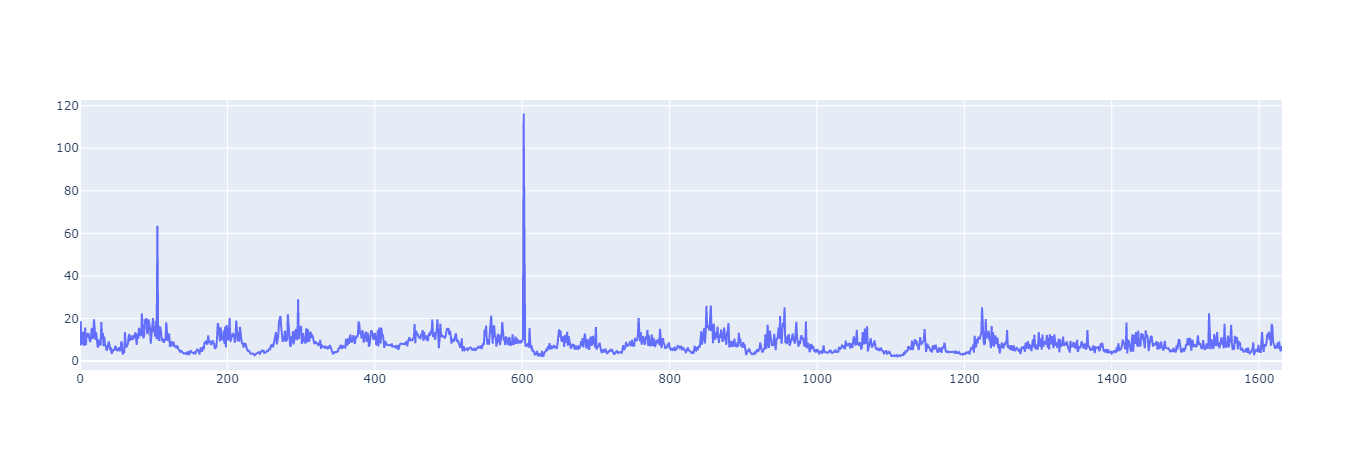

In [60]:
go.Figure(data = go.Scatter(y = data_ha_use[target], x = data_ha_use.index, mode='lines'))

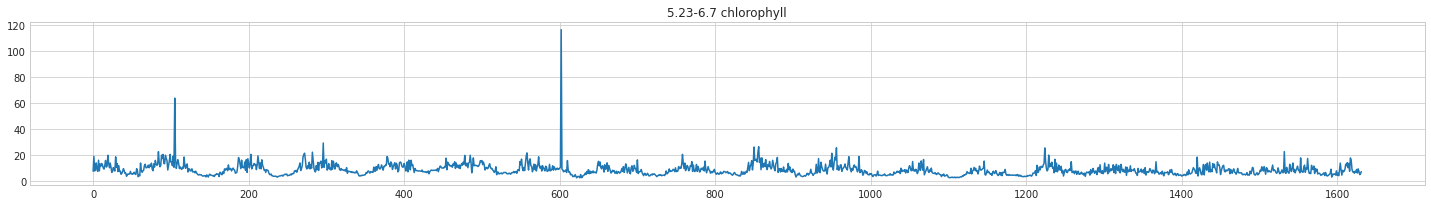

In [61]:
plt.figure(figsize = (25,3))
plt.plot(data_ha_use[target])
plt.title("5.23-6.7 " + target);

In [62]:
# parameters = {'max_depth': list(range(1, 21, 5)), 
#               'min_samples_leaf': list(range(1, 6, 2)), 
#               'min_samples_split':list(range(1, 6, 2)), 
#               'n_estimators': list(range(100, 200, 20))}

### 기본 설정
lag_term = 3
Random_state = 717
before_y = "no"
hs = "yes"
# MODELS = [RandomForestRegressor(random_state = Random_state), ExtraTreesRegressor(random_state = Random_state), AdaBoostRegressor(random_state = Random_state), xgboost.XGBRegressor(random_state = Random_state), 
#           GradientBoostingRegressor(random_state = Random_state), LGBMRegressor(random_state = Random_state), CatBoostRegressor(random_state = Random_state, verbose = 0)]
MODELS = [RandomForestRegressor(random_state = Random_state), xgboost.XGBRegressor(random_state = Random_state), LGBMRegressor(random_state = Random_state)]

In [63]:
### 기본 모델
model = trc.HS_model(data_ha_train, MODEL = GradientBoostingRegressor(random_state = Random_state), lag_term = lag_term, before_y = before_y, hs = hs, target = target)["model"]
print(model)

GradientBoostingRegressor(random_state=717)


In [64]:
import warnings
warnings.filterwarnings('ignore')

### 예측 과정
dataset = data_ha_train.copy()    # 데이터가 쌓일 공간
preds = []
pred_X_df = pd.DataFrame()
for i in tqdm(range(data_ha_test.shape[0])) :
    
    dataset = dataset.append(data_ha_test.iloc[[i]])
    last_data = dataset.iloc[[-1]]
    
    """ 매 0시0분 Model Update """
    if (last_data["Hour"].values == 0) & (last_data["Min"].values == 0) :
        print("\033[31m" +"%d년 %d월 %d일 %d시 %d분 Model Update 수행합니다." % (last_data["Year"], last_data["Month"], last_data["Day"], last_data["Hour"], last_data["Min"]) + "\033[0m")
        
        start_time = time.time()
        
        hs_models, models = [], []
        for j in range(len(MODELS)) :
            hs_model = trc.HS_model(dataset, MODEL = MODELS[j], lag_term = lag_term, before_y = before_y, hs = hs, target = target)
            hs_models.append(hs_model)
            models.append(hs_model["model"])

        train_pls = hs_models[0]["train pls"]
        train_std_other = hs_models[0]["train std other"]
        train_std_reflec = hs_models[0]["train std reflec"]
        train_columns = hs_models[0]["train columns"]
        
        end_time = time.time()
        print("%.3f 경과시간" % (np.round(end_time- start_time, 3)))

        
    else :
        pass
    
    """ Prediction """
    pred_X = tec.testlag_(dataset, last_data, lag_term = lag_term, before_y = before_y)
    pred_X = tec.prep_data_with_y(pred_X, train_pls, train_std_other, train_std_reflec, hs = hs)
    pred_X = pred_X[train_columns]
    pred_X_df = pd.concat([pred_X_df, pred_X], axis = 0)    
    
    pred_list = []
    for j in range(len(models)) :
        pred_ = models[j].predict(pred_X)[0]
        pred_list.append(pred_)
        
    pred = np.mean(pred_list)
    
    preds.append(pred)   
    
    if i%50 == 0 :
        print("%d년 %d월 %d일 %d시 %d분 + 15분 후 예측값 : %.4f" % (last_data["Year"], last_data["Month"], last_data["Day"], last_data["Hour"], last_data["Min"], pred))

  0%|          | 0/96 [00:00<?, ?it/s]

2022년 6월 7일 0시 0분 Model Update 수행합니다.
2.153 경과시간
2022년 6월 7일 0시 0분 + 15분 후 예측값 : 11.3369
2022년 6월 7일 12시 30분 + 15분 후 예측값 : 6.3281


R-square(OLS) :  0.164
R-square(sklearn) :  -2.483
Correlation :  0.405
MAPE :  64.238


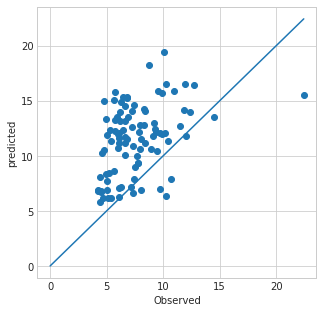

In [65]:
observed = list(data_ha_test.loc[1:, target].reset_index(drop = True))
preds2 = preds[:-1]

print("R-square(OLS) : ", R2_OLS(observed, preds2))
print("R-square(sklearn) : ", np.round(r2_score(observed, preds2), 3))
print("Correlation : ", np.round(np.corrcoef(observed, preds2)[0,1], 3))
print("MAPE : ", MAPE(observed, preds2))

plt.figure(figsize = (5,5))
plt.scatter(observed, preds2)
plt.xlabel("Observed") ; plt.ylabel("predicted")
plt.plot([0, max(max(observed), max(preds2))], [0, max(max(observed), max(preds2))]);

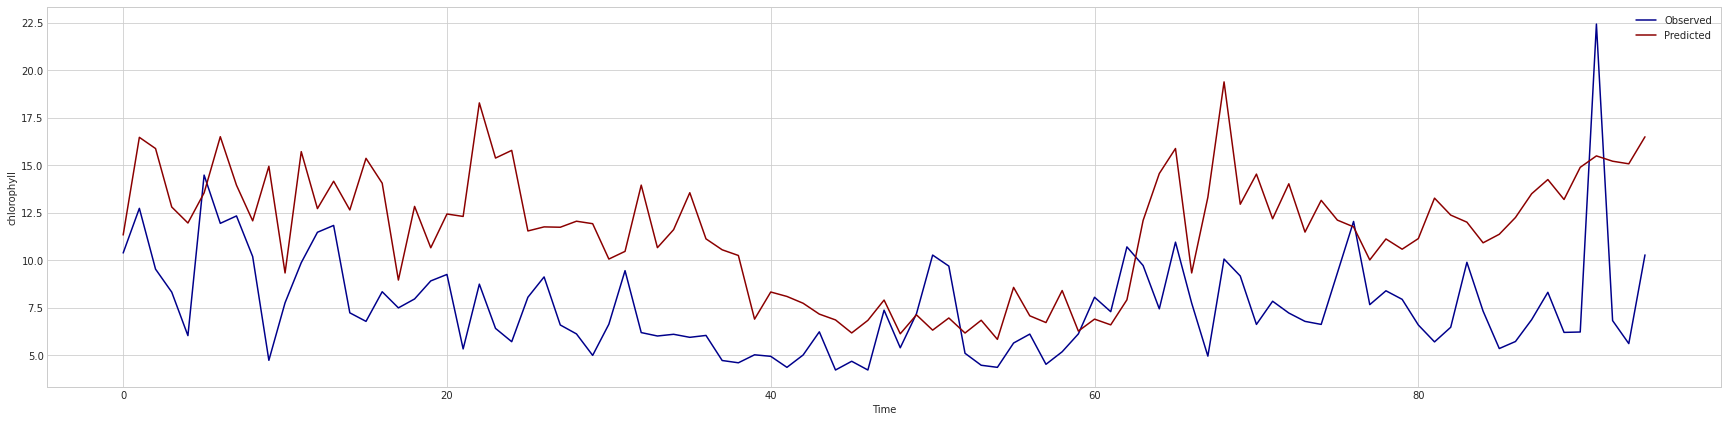

In [66]:
plt.figure(figsize = (30, 7))
plt.plot(observed, color = "darkblue", label = "Observed")
plt.plot(preds2, color = "darkred", label = "Predicted")
plt.xlabel("Time") ; plt.ylabel(target)

plt.legend();

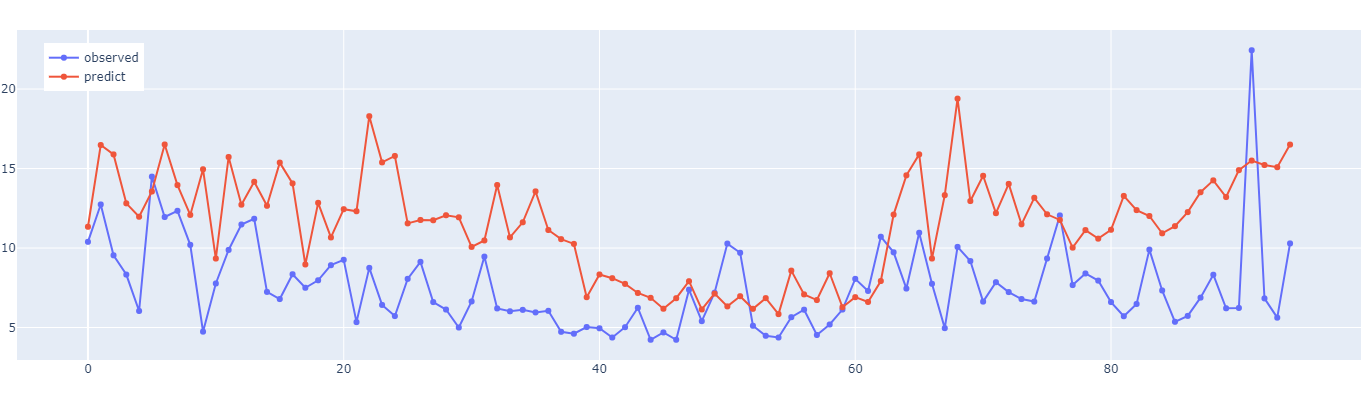

In [67]:
fig = go.Figure()
fig.update_layout(width = 1450, height = 400, margin = dict(l = 1, r = 1, t = 30, b = 40),
                  legend = dict(yanchor='top', y=0.96, xanchor='left', x=0.02))
fig.add_trace(go.Scatter(y = observed, x = list(range(len(observed))), mode = 'lines+markers', name = "observed"))
fig.add_trace(go.Scatter(y = preds2, x = list(range(len(preds2))), mode = 'lines+markers', name = "predict"))
fig.show();

# **Model - HA (chla)**

In [2]:
target = "chla"

In [3]:
data_ha = pd.read_csv("../DAT/complete_data(haman-chla).csv")
data_ha = data_ha.fillna(0)

In [4]:
condlist = [((data_ha["Month"] == 5) & (data_ha["Day"] >= 23)), ((data_ha["Month"] == 6) & (data_ha["Day"] <= 8))]
choicelist = [1, 1]
use = np.select(condlist, choicelist).astype("int")
data_ha["use"] = use

data_ha_use = data_ha[data_ha["use"] == 1]
data_ha_use.drop(columns = ["use"], inplace = True)
data_ha_use.reset_index(drop = True, inplace = True)
data_ha_use.head(3)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Year  Month  Day  Hour  Min  chlorophyll  conductivity     do     ph  \
0  2022      5   23     0    0         7.29        377.99  11.93  8.728   
1  2022      5   23     0   15        18.72        377.76  11.96  8.730   
2  2022      5   23     0   30         7.44        378.67  11.86  8.703   

   phycocyanin  ...  reflectance.541  reflectance.542  reflectance.543  \
0         0.26  ...              0.0              0.0              0.0   
1         0.29  ...              0.0              0.0              0.0   
2         0.23  ...              0.0              0.0              0.0   

   reflectance.544  reflectance.545  reflectance.546  reflectance.547  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   

   reflectance.548  reflectance.549  reflectance.550  
0              0.0              0.0              0.0  
1              0.0              0.0              0.0  
2              0.0              0.0              0.0  

[3 rows x 570 columns]

In [5]:
data_ha_train = data_ha_use[(data_ha_use["Month"] != 6) & (data_ha_use["Day"] != 7)].reset_index(drop=True)
data_ha_test = data_ha_use[(data_ha_use["Month"] == 6) & (data_ha_use["Day"] == 7)].reset_index(drop=True)

print(data_ha_train.shape, data_ha_test.shape)

(864, 570) (96, 570)


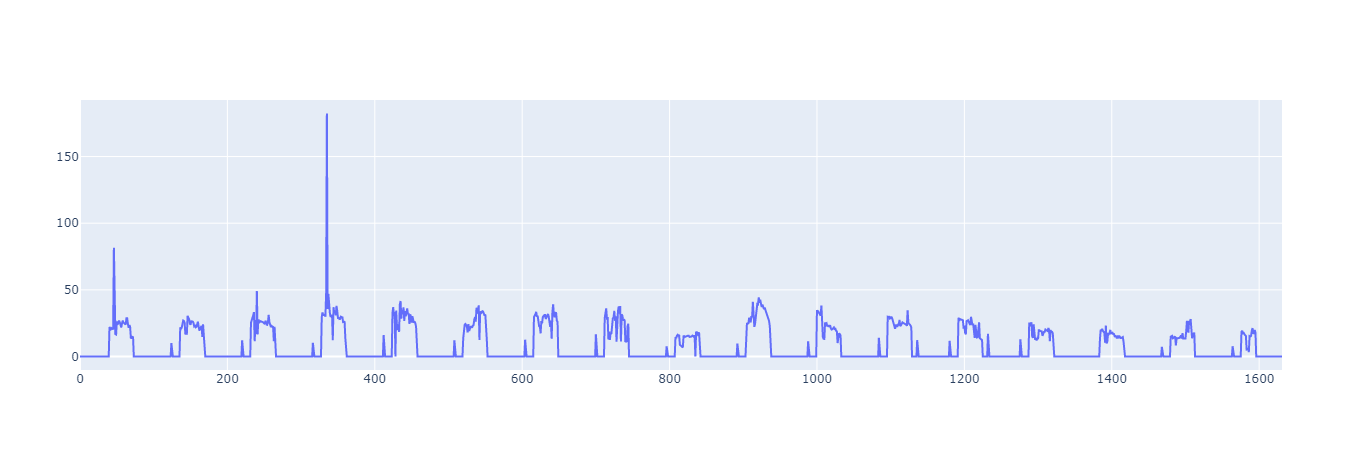

In [6]:
go.Figure(data = go.Scatter(y = data_ha_use[target], x = data_ha_use.index, mode='lines'))

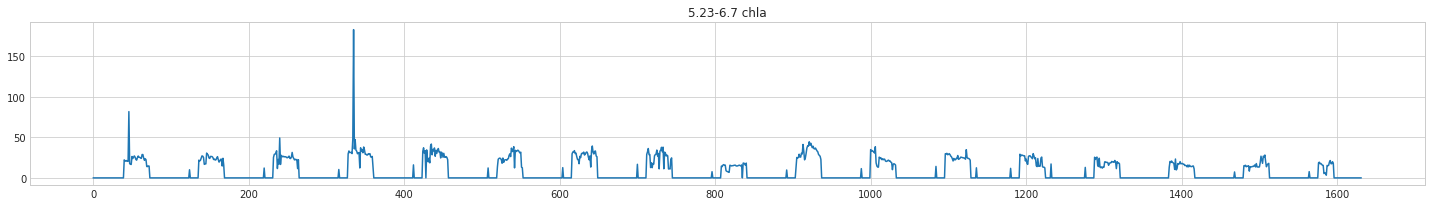

In [7]:
plt.figure(figsize = (25,3))
plt.plot(data_ha_use[target])
plt.title("5.23-6.7 " + target);

In [8]:
# parameters = {'max_depth': list(range(1, 21, 5)), 
#               'min_samples_leaf': list(range(1, 6, 2)), 
#               'min_samples_split':list(range(1, 6, 2)), 
#               'n_estimators': list(range(100, 200, 20))}

### 기본 설정
lag_term = 3
Random_state = 717
before_y = "no"
hs = "yes"
# MODELS = [RandomForestRegressor(random_state = Random_state), ExtraTreesRegressor(random_state = Random_state), AdaBoostRegressor(random_state = Random_state), xgboost.XGBRegressor(random_state = Random_state), 
#           GradientBoostingRegressor(random_state = Random_state), LGBMRegressor(random_state = Random_state), CatBoostRegressor(random_state = Random_state, verbose = 0)]
MODELS = [RandomForestRegressor(random_state = Random_state), xgboost.XGBRegressor(random_state = Random_state), LGBMRegressor(random_state = Random_state)]

In [9]:
### 기본 모델
model = trc.HS_model(data_ha_train, MODEL = GradientBoostingRegressor(random_state = Random_state), lag_term = lag_term, before_y = before_y, hs = hs, target = target)["model"]
print(model)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:573: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



GradientBoostingRegressor(random_state=717)


In [10]:
import warnings
warnings.filterwarnings('ignore')

### 예측 과정
dataset = data_ha_train.copy()    # 데이터가 쌓일 공간
preds = []
pred_X_df = pd.DataFrame()
for i in tqdm(range(data_ha_test.shape[0])) :
    
    dataset = dataset.append(data_ha_test.iloc[[i]])
    last_data = dataset.iloc[[-1]]
    
    """ 매 0시0분 Model Update """
    if (last_data["Hour"].values == 0) & (last_data["Min"].values == 0) :
        print("\033[31m" +"%d년 %d월 %d일 %d시 %d분 Model Update 수행합니다." % (last_data["Year"], last_data["Month"], last_data["Day"], last_data["Hour"], last_data["Min"]) + "\033[0m")
        
        start_time = time.time()
        
        hs_models, models = [], []
        for j in range(len(MODELS)) :
            hs_model = trc.HS_model(dataset, MODEL = MODELS[j], lag_term = lag_term, before_y = before_y, hs = hs, target = target)
            hs_models.append(hs_model)
            models.append(hs_model["model"])

        train_pls = hs_models[0]["train pls"]
        train_std_other = hs_models[0]["train std other"]
        train_std_reflec = hs_models[0]["train std reflec"]
        train_columns = hs_models[0]["train columns"]
        
        end_time = time.time()
        print("%.3f 경과시간" % (np.round(end_time- start_time, 3)))

        
    else :
        pass
    
    """ Prediction """
    pred_X = tec.testlag_(dataset, last_data, lag_term = lag_term, before_y = before_y)
    pred_X = tec.prep_data_with_y(pred_X, train_pls, train_std_other, train_std_reflec, hs = hs)
    pred_X = pred_X[train_columns]
    pred_X_df = pd.concat([pred_X_df, pred_X], axis = 0)    
    
    pred_list = []
    for j in range(len(models)) :
        pred_ = models[j].predict(pred_X)[0]
        pred_list.append(pred_)
        
    pred = np.mean(pred_list)
    
    preds.append(pred)   
    
    if i%50 == 0 :
        print("%d년 %d월 %d일 %d시 %d분 + 15분 후 예측값 : %.4f" % (last_data["Year"], last_data["Month"], last_data["Day"], last_data["Hour"], last_data["Min"], pred))

  0%|          | 0/96 [00:00<?, ?it/s]

2022년 6월 7일 0시 0분 Model Update 수행합니다.
1.986 경과시간


KeyError: "['chlorophyll_lag_1', 'chlorophyll_lag_2', 'chlorophyll_lag_3'] not in index"

R-square(OLS) :  0.164
R-square(sklearn) :  -2.483
Correlation :  0.405
MAPE :  64.238


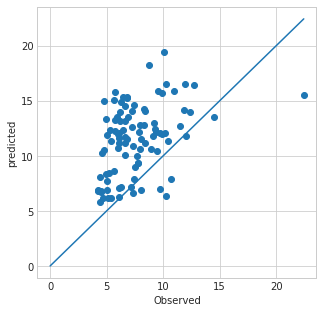

In [65]:
observed = list(data_ha_test.loc[1:, target].reset_index(drop = True))
preds2 = preds[:-1]

print("R-square(OLS) : ", R2_OLS(observed, preds2))
print("R-square(sklearn) : ", np.round(r2_score(observed, preds2), 3))
print("Correlation : ", np.round(np.corrcoef(observed, preds2)[0,1], 3))
print("MAPE : ", MAPE(observed, preds2))

plt.figure(figsize = (5,5))
plt.scatter(observed, preds2)
plt.xlabel("Observed") ; plt.ylabel("predicted")
plt.plot([0, max(max(observed), max(preds2))], [0, max(max(observed), max(preds2))]);

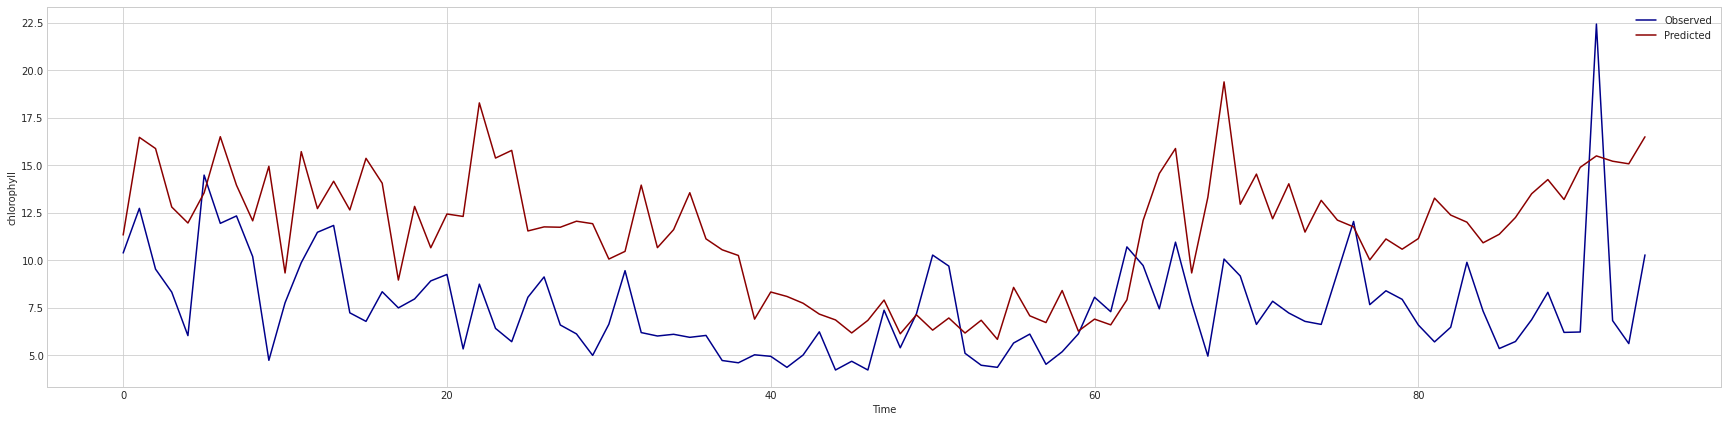

In [66]:
plt.figure(figsize = (30, 7))
plt.plot(observed, color = "darkblue", label = "Observed")
plt.plot(preds2, color = "darkred", label = "Predicted")
plt.xlabel("Time") ; plt.ylabel(target)

plt.legend();

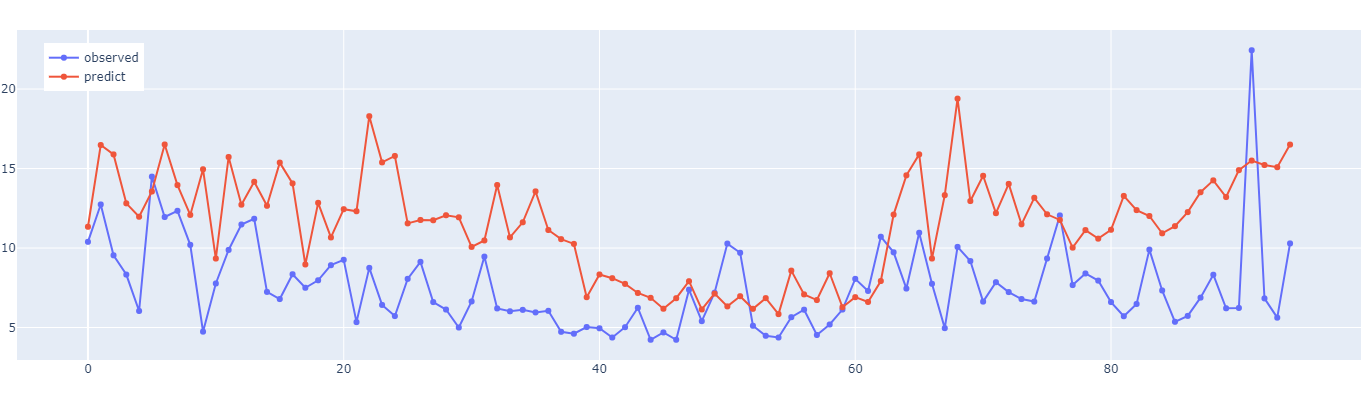

In [67]:
fig = go.Figure()
fig.update_layout(width = 1450, height = 400, margin = dict(l = 1, r = 1, t = 30, b = 40),
                  legend = dict(yanchor='top', y=0.96, xanchor='left', x=0.02))
fig.add_trace(go.Scatter(y = observed, x = list(range(len(observed))), mode = 'lines+markers', name = "observed"))
fig.add_trace(go.Scatter(y = preds2, x = list(range(len(preds2))), mode = 'lines+markers', name = "predict"))
fig.show();